<a href="https://colab.research.google.com/github/Svensone/fast.ai-coursev3/blob/master/lesson6_Rossmann_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Lesson 6 - Rossmann Sales Regression

1. Setup
2. Data
3. Model

In [1]:
# Setup
%reload_ext autoreload
%autoreload 2

from fastai.tabular import *

In [2]:
## Rossmann (Sales Prediction on tabular data)

## 2. Data 

1. from Kaggle
kaggle kernels pull init27/fastai-v3-rossman-data-clean

2. with rossmann_data_clean.ipynb

In [8]:
test_df = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/fast.ai/lesson6/test_clean')

train_df = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/fast.ai/lesson6/train_clean')

In [14]:
train_df.head()

,index,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,State,file,week,trend,file_DE,week_DE,trend_DE,Date_DE,...,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,Mean_Sea_Level_PressurehPa,Min_Sea_Level_PressurehPa,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees,StateName,CompetitionOpenSince,CompetitionDaysOpen,CompetitionMonthsOpen,Promo2Since,Promo2Days,Promo2Weeks,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,0,1,5,2015-07-31,5263,555,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,c,a,1270.0,9,2008,0,1,1900,NaN,HE,Rossmann_DE_HE,2015-08-02 - 2015-08-08,85,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,...,16,8,9,6,3,98,54,18,1021,1018,1015,31.0,15.0,10.0,24,11,NaN,0.0,1.0,Fog,13,Hessen,2008-09-15,2510,24,1900-01-01,0,0,0,0,57,0,0,0,5.0,0.0,5.0,7.0,0.0,5.0
1,1,2,5,2015-07-31,6064,625,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",TH,Rossmann_DE_TH,2015-08-02 - 2015-08-08,80,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,...,13,7,9,6,3,100,62,25,1021,1019,1017,10.0,10.0,10.0,14,11,NaN,0.0,4.0,Fog,309,Thueringen,2007-11-15,2815,24,2010-03-29,1950,25,0,0,67,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
2,2,3,5,2015-07-31,8314,821,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",NW,Rossmann_DE_NW,2015-08-02 - 2015-08-08,86,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,...,13,6,10,7,4,100,61,24,1022,1019,1017,31.0,14.0,10.0,14,5,NaN,0.0,2.0,Fog,354,NordrheinWestfalen,2006-12-15,3150,24,2011-04-04,1579,25,0,0,57,0,0,0,5.0,0.0,5.0,5.0,0.0,5.0
3,3,4,5,2015-07-31,13995,1498,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,c,c,620.0,9,2009,0,1,1900,NaN,BE,Rossmann_DE_BE,2015-08-02 - 2015-08-08,74,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,...,14,9,9,7,4,94,61,30,1019,1017,1014,10.0,10.0,10.0,23,16,NaN,0.0,6.0,NaN,282,Berlin,2009-09-15,2145,24,1900-01-01,0,0,0,0,67,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
4,4,5,5,2015-07-31,4822,559,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,a,a,29910.0,4,2015,0,1,1900,NaN,SN,Rossmann_DE_SN,2015-08-02 - 2015-08-08,82,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,...,15,10,8,6,5,82,55,26,1020,1018,1016,10.0,10.0,10.0,14,11,NaN,0.0,4.0,NaN,290,Sachsen,2015-04-15,107,3,1900-01-01,0,0,0,0,57,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0


In [10]:
# check if the same length

n= len(train_df); n

844338

In [12]:
# create Small Subset for testing

idx = np.random.permutation(range(n))[:2000] #first 2000 instances after random shuffle
idx.sort()

small_train_df = train_df.iloc[idx[:1000]]
small_test_df = train_df.iloc[idx[1000:]]

small_cont_vars = ['CompetitionDistance', 'Mean_Humidity']
small_cat_vars =  ['Store', 'DayOfWeek', 'PromoInterval']

small_train_df = small_train_df[small_cont_vars + small_cat_vars + ["Sales"]]
small_test_df = small_test_df[small_cont_vars + small_cat_vars + ['Sales']]

In [13]:
small_train_df.tail()

,CompetitionDistance,Mean_Humidity,Store,DayOfWeek,PromoInterval,Sales
432405,11400.0,42,443,4,NaN,5513
432443,7470.0,55,481,4,"Feb,May,Aug,Nov",3842
432493,1070.0,49,532,4,NaN,9310
432862,3170.0,51,901,4,NaN,7420
433552,320.0,69,479,3,"Feb,May,Aug,Nov",11096


In [15]:
# preproccessing the data manually (normally procs in DataBunch creation)

categorify = Categorify(small_cat_vars, small_cont_vars )
categorify(small_train_df)
categorify(small_test_df)

# print out the same (easier readable - under the hood as category)
small_test_df.head()

,CompetitionDistance,Mean_Humidity,Store,DayOfWeek,PromoInterval,Sales
434225,1090.0,75,38,2,NaN,7008
435912,3040.0,70,616,1,"Mar,Jun,Sept,Dec",11079
436044,2380.0,70,748,1,"Jan,Apr,Jul,Oct",7772
436344,370.0,66,1049,1,"Jan,Apr,Jul,Oct",4817
436379,4030.0,75,1085,1,NaN,9900


In [16]:
# check categories of PromoInterval

small_test_df.PromoInterval.cat.categories

Index(['Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec'], dtype='object')

In [17]:
small_test_df["PromoInterval"].cat.codes[:5]

434225   -1
435912    2
436044    1
436344    1
436379   -1
dtype: int8

In [19]:
fill_missing = FillMissing(small_cat_vars, small_cont_vars)
fill_missing(small_train_df)
fill_missing(small_test_df)

## 2.3 Preparing full data set

In [20]:
test_df = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/fast.ai/lesson6/test_clean')
train_df = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/fast.ai/lesson6/train_clean')

In [21]:
len(train_df), len(test_df)

(844338, 41088)

In [43]:
# automatic preprocessing in fast.ai

procs=[FillMissing, Categorify, Normalize]

# even  years, day etc as cat. vars (rule of thumb: low cardinality -> cat. vars since embeddings faster training)
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

dep_var = 'Sales'
df = train_df[cat_vars + cont_vars + [dep_var,'Date']].copy()



In [44]:
test_df["Date"].min(), test_df['Date'].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

In [45]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
cut

41395

In [46]:
valid_idx = range(cut)
valid_idx

range(0, 41395)

In [47]:
df.Sales.head() #dtype is int64 -> to float

0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

In [48]:
# DataBunch
path = Path('/content/drive/My Drive/Colab Notebooks/fast.ai/lesson6')

data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                .add_test(TabularList.from_df(test_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())

# label_cls traonsforms to Float numbers - fastai autom. makes Regression(otherwise Classifi), log=True since evaluation metrics RMSPE

In [ ]:
help(FloatList) 
doc(FloatList)

## 3 Model

1. Model
2. Train
3. Inference

In [57]:
# define y-range

max_log_y = np.log(np.max(train_df.Sales)*1.2)
# always better when y-range bigger then max value

y_range = torch.tensor([0, max_log_y], device=defaults.device)


In [58]:
doc(tabular_learner)

In [59]:
# define model (2 FC-layers, Dropout ps , emb_drop=0.04 )

learn = tabular_learner(data, layers=[1000, 500], ps=[0.001, 0.01], emb_drop=0.04, 
                        y_range = y_range, metrics = exp_rmspe)

In [60]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(26, 10)
    (7): Embedding(27, 10)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 15)
    (15): Embedding(22, 9)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=233, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_runn

In [61]:
len(data.train_ds.cont_names)

16

In [62]:
len(data.train_ds.cat_names)

24

epoch,train_loss,valid_loss,exp_rmspe,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-02
Min loss divided by 10: 2.75E-01


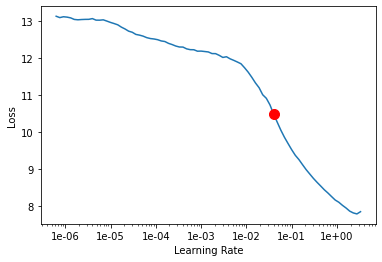

In [63]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(5, 3e-2, wd= 0.2)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.055916,0.061172,0.213693,08:19


In [ ]:
learn.save('1')

learn.recorder.plot_losses()

In [ ]:
# learn.load("1")

# learn.fit_one_cycle(5, 3e-4)

In [ ]:
# learn.fit_one_cycle(5, 3e-4)

## 3.3 Inference

In [ ]:
test_preds = learn.get_preds(DatasetType.Test)

test_preds[:5]


In [ ]:
test_df['Sales'] = np.exp(test_preds[0].data).numpy().T[0]

#change columns to integers
test_df[['Id', "Sales"]] = test_ds[["Id", 'Sales']].astype('int')

#create csv
test_df[['Id', 'Sales']].to_csv('rossmann_submission.csv', index=False)